In [13]:
#### Load Text
#### Setup

!pip install tf-nightly
import tensorflow as tf

In [14]:
from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_datasets as tfds
tfds.disable_progress_bar()

In [15]:
#### Using the Embedding layer 
embedding_layer = layers.Embedding(1000, 5)

In [16]:
result = embedding_layer(tf.constant([1,2,3]))
result.numpy()

array([[-0.01309192, -0.03393791, -0.03152492, -0.00718639,  0.0239575 ],
       [ 0.03101293,  0.04048166, -0.00649827, -0.02838457,  0.00106522],
       [-0.02751148, -0.0394739 , -0.02834838, -0.04316802, -0.0018381 ]],
      dtype=float32)

In [21]:
result = embedding_layer(tf.constant([[0,1,2],[3,4,5]]))
result.shape

TensorShape([2, 3, 5])

In [22]:
#### Learning embeddings from scratch

(train_data, test_data), info = tfds.load(
    'imdb_reviews/subwords8k', 
    split = (tfds.Split.TRAIN, tfds.Split.TEST), 
    with_info=True, as_supervised=True)

In [25]:
encoder = info.features['text'].encoder
encoder.subwords[:20]

['the_',
 ', ',
 '. ',
 'a_',
 'and_',
 'of_',
 'to_',
 's_',
 'is_',
 'br',
 'in_',
 'I_',
 'that_',
 'this_',
 'it_',
 ' /><',
 ' />',
 'was_',
 'The_',
 'as_']

In [26]:
train_data

<_OptionsDataset shapes: ((None,), ()), types: (tf.int64, tf.int64)>

In [27]:
train_batches = train_data.shuffle(1000).padded_batch(10, padded_shapes=([None],[]))
test_batches = test_data.shuffle(1000).padded_batch(10, padded_shapes=([None],[]))

In [28]:
train_batches = train_data.shuffle(1000).padded_batch(10)
test_batches = test_data.shuffle(1000).padded_batch(10)

In [31]:
train_batch, train_labels = next(iter(train_batches))
train_batch.numpy()

array([[  62,    9,   82, ...,    0,    0,    0],
       [4728,    2,    1, ...,    0,    0,    0],
       [3317, 8030,  106, ...,    0,    0,    0],
       ...,
       [ 373,    6,    1, ...,    0,    0,    0],
       [  12,  290,   31, ...,    0,    0,    0],
       [  62,    9,   82, ...,    0,    0,    0]], dtype=int64)

In [33]:
#### Create a simple model
#### We will use the Keras Sequential API to define our model. 
#### In this case it is a "Continuous bag of words" style model.

# Next the Embedding layer takes the integer-encoded vocabulary and looks up the embedding vector for each word-index. 
# These vectors are learned as the model trains. The vectors add a dimension to the output array. 
# The resulting dimensions are: (batch, sequence, embedding).

# Next, a GlobalAveragePooling1D layer returns a fixed-length output vector for each example by averaging over the sequence dimension. 
# This allows the model to handle input of variable length, in the simplest way possible.

# This fixed-length output vector is piped through a fully-connected (Dense) layer with 16 hidden units.

# The last layer is densely connected with a single output node. Using the sigmoid activation function, 
# this value is a float between 0 and 1, representing a probability (or confidence level) that the review is positive.

embedding_dim=16

model = keras.Sequential([
  layers.Embedding(encoder.vocab_size, embedding_dim),
  layers.GlobalAveragePooling1D(),
  layers.Dense(16, activation='relu'),
  layers.Dense(1)
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 16)          130960    
_________________________________________________________________
global_average_pooling1d_1 ( (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 131,249
Trainable params: 131,249
Non-trainable params: 0
_________________________________________________________________


In [34]:
#### Compile and train the model

model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(
    train_batches,
    epochs=10,
    validation_data=test_batches, validation_steps=20)

Instructions for updating:
Use `tf.data.Dataset.cardinality()


Instructions for updating:
Use `tf.data.Dataset.cardinality()


Epoch 1/10
   2491/Unknown - 6s 2ms/step - loss: 0.5131 - accuracy: 0.6991WARNING:tensorflow:Callbacks method `on_test_batch_begin` is slow compared to the batch time. Check your callbacks.


2500/2500 [==============================] - 6s 2ms/step - loss: 0.5128 - accuracy: 0.6994 - val_loss: 0.3789 - val_accuracy: 0.8650
Epoch 2/10
2500/2500 [==============================] - 7s 3ms/step - loss: 0.2845 - accuracy: 0.8829 - val_loss: 0.3460 - val_accuracy: 0.8550
Epoch 3/10
2500/2500 [==============================] - 7s 3ms/step - loss: 0.2331 - accuracy: 0.9073 - val_loss: 0.2797 - val_accuracy: 0.8850
Epoch 4/10
2500/2500 [==============================] - 7s 3ms/step - loss: 0.1992 - accuracy: 0.9232 - val_loss: 0.2906 - val_accuracy: 0.9050
Epoch 5/10
2500/2500 [==============================] - 6s 2ms/step - loss: 0.1761 - accuracy: 0.9356 - val_loss: 0.3060 - val_accuracy: 0.8800
Epoch 6/10
2500/2500 [==============================] - 7s 3ms/step - loss: 0.1584 - accuracy: 0.9425 - val_loss: 0.3423 - val_accuracy: 0.8350
Epoch 7/10
2500/2500 [==============================] - 7s 3ms/step - loss: 0.1444 - accuracy: 0.9482 - val_loss: 0.3561 - val_accuracy: 0.8700
Epo

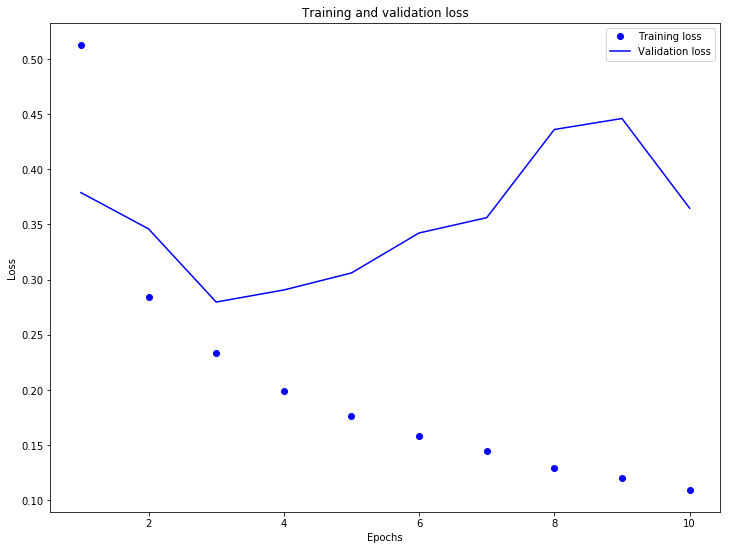

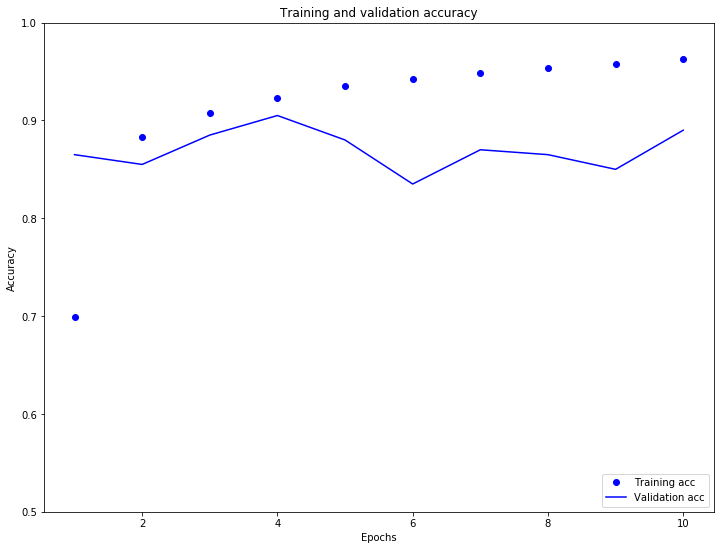

In [36]:
import matplotlib.pyplot as plt

history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss=history_dict['loss']
val_loss=history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,9))
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(12,9))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim((0.5,1))
plt.show()

In [37]:
#### Retrieve the learned embeddings
#### Next, let's retrieve the word embeddings learned during training. This will be a matrix of shape (vocab_size, embedding-dimension).

e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

(8185, 16)


In [40]:
#### We will now write the weights to disk. 
#### To use the Embedding Projector, we will upload two files in tab separated format: 
#### a file of vectors (containing the embedding), and a file of meta data (containing the words).

import io

encoder = info.features['text'].encoder

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')

for num, word in enumerate(encoder.subwords):
  vec = weights[num+1] # skip 0, it's padding.
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
out_v.close()
out_m.close()

In [42]:
try:
  from google.colab import files
except ImportError:
   pass
else:
  files.download('vecs.tsv')
  files.download('meta.tsv')

In [ ]:
#### Visualize the embeddings
#### To visualize our embeddings we will upload them to the embedding projector.
#### Open the Embedding Projector : http://projector.tensorflow.org/ (this can also run in a local TensorBoard instance).
#### Click on "Load data".
#### Upload the two files we created above: vecs.tsv and meta.tsv.